# Loading preprocessed data

In [1]:
import numpy as np
import math
# import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, LearningRateScheduler
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D, Input, MaxPooling2D, Add, GlobalAveragePooling2D, Reshape, Bidirectional, Dense, Flatten, Dropout, SpatialDropout2D
from keras.layers import LSTM, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adadelta
from time import time
from collections import Counter
import matplotlib.pyplot as plt
import os
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix   
import wave
import librosa
import soundfile as sf
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20,7)

In [5]:
class ResNetLstm():
    """
    Usage: 
        sr = ResNetLstm([4,8,16], input_size=(50,50,1), output_size=12)
        sr.build()
        followed by sr.m.compile(loss='categorical_crossentropy', 
                                 optimizer='adadelta', metrics=["accuracy"])
        save plotted model with: 
            keras.utils.plot_model(sr.m, to_file = '<location>.png', 
                                   show_shapes=True)
    """
    def __init__(self,
                 filters_list=[], 
                 input_size=None, 
                 output_size=None,
                 initializer='glorot_uniform'):
        self.filters_list = filters_list
        self.input_size = input_size
        self.output_size = output_size
        self.initializer = initializer
        self.m = None        
    
    def _block(self, filters, inp):
        """ one residual block in a ResNetLstm
        
        Args:
            filters (int): number of convolutional filters
            inp (tf.tensor): output from previous layer
            
        Returns:
            tf.tensor: output of residual block
        """
        layer_1 = BatchNormalization()(inp)
        act_1 = Activation('relu')(layer_1)
        conv_1 = Conv2D(filters, (3,3), 
                        padding = 'same', 
                        kernel_initializer = self.initializer)(act_1)
        layer_2 = BatchNormalization()(conv_1)
        act_2 = Activation('relu')(layer_2)
        conv_2 = Conv2D(filters, (3,3), 
                        padding = 'same', 
                        kernel_initializer = self.initializer)(act_2)
        return(conv_2)
    def build(self):
        """
        Returns:
            keras.engine.training.Model
        """

        print('1shapes: ', self.input_size)
        i = Input(shape = self.input_size, name = 'input')
        x = Conv2D(self.filters_list[0], (3,3), 
                   padding = 'same',
                   kernel_initializer = self.initializer)(i)
        print('2shapes: ', x.shape)
        x = MaxPooling2D((1,3))(x)
        # x = MaxPooling2D(padding = 'same')(x)
        print('3shapes: ', x.shape)
        x = Add()([self._block(self.filters_list[0], x),x])
        x = Add()([self._block(self.filters_list[0], x),x])
        x = Add()([self._block(self.filters_list[0], x),x])
        if len(self.filters_list) > 1:
            for filt in self.filters_list[1:]:
                print(filt)
                x = Conv2D(filt, (3,3),
                           strides = (1,1),
                           padding = 'same',
                           activation = 'relu',
                           kernel_initializer = self.initializer)(x)
                x = MaxPooling2D((1,3))(x)
                print('6shapes: ', x.shape)
                x = Add()([self._block(filt, x),x])
                x = Add()([self._block(filt, x),x])
                x = Add()([self._block(filt, x),x])
        # x = GlobalAveragePooling2D()(x)
        
        x = Reshape((85,4*32))(x)
        print('7shapes: ', x.shape)
        x = Bidirectional(LSTM(64,return_sequences=True))(x)
        print('8shapes: ', x.shape)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Bidirectional(LSTM(32,return_sequences=True))(x)
        print('9shapes: ', x.shape)
        x = Reshape((85,2*32))(x)
        print('0shapes: ', x.shape)
        print('output_size: ', self.output_size)
        x = Flatten()(x)
        print('1shapes: ', x.shape)
        x = Dropout(0.2)(x)
        
        x = Dense(self.output_size, activation = 'softmax')(x)
        print('2shapes: ', x.shape)
        
        self.m = Model(i,x)
        return self.m

In [6]:
# temporarely unused
def load_wave(filename):
   # Read file to get buffer                                                                                               
   ifile = wave.open(filename)
   samples = ifile.getnframes()
   audio = ifile.readframes(samples)

   # Convert buffer to float32 using NumPy                                                                                 
   audio_as_np_int16 = np.frombuffer(audio, dtype=np.int16)
   audio_as_np_float32 = audio_as_np_int16.astype(np.float32)

   # Normalise float32 array so that values are between -1.0 and +1.0                                                      
   max_int16 = 2**15
   audio_normalised = audio_as_np_float32 / max_int16
   return audio_normalised

### import training and validation data (not included in repo)

In [7]:
# data_path = './'
data_path = '/dev/shm/kmrozowski/'
# data_path = '/home2/faculty/kmrozowski/rl2/wut-mini-deep-learning/speech-recognition/'
# data_path = '/home/metiulekm/wut-mini-deep-learning/speech-recognition/'
X_train = np.load(data_path + 'data/X_train.npy').transpose((0,2,1,3))
Y_train = np.load(data_path + 'data/Y_train.npy')
#X_train = X_train[1::100, ...]
#Y_train = Y_train[1::100, ...]
X_val = np.load(data_path + 'data/X_val.npy').transpose((0,2,1,3))
Y_val = np.load(data_path + 'data/Y_val.npy')

In [8]:
X_train_flipped = np.flip(X_train, 2)
Y_train_flipped = Y_train.copy()
Y_train_flipped[Y_train != 10] = 11
X_train = np.append(X_train, X_train_flipped, 0)
Y_train = np.append(Y_train, Y_train_flipped)

In [9]:
X_train.shape
# (58284, 122, 85, 1) -> (n_samples, frequencies, timestamps, 1)

(116568, 85, 122, 1)

In [10]:
Y_train.shape

(116568,)

In [11]:
#path = '/home/metiulekm/wut-mini-deep-learning/speech-recognition/'
daata_path = '/dev/shm/kmrozowski/'
classes = ['yes', 'no', 
           'up', 'down', 
           'left', 'right', 
           'on', 'off', 
           'stop', 'go', 
           'silence', 'unknown']
all_classes = [x for x in classes[:11]]
for ind, cl in enumerate(os.listdir(daata_path + 'data/train/audio/')):
    if cl not in classes:
        all_classes.append(cl)
classes_binary = ['known', 'unknown']
classes_known = classes[:-1]
print(all_classes, '-->', classes_binary, '-->', classes_known)

['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'zero', 'wow', 'two', 'tree', 'three', 'six', 'sheila', 'seven', 'one', 'nine', 'marvin', 'house', 'happy', 'four', 'five', 'eight', 'dog', 'cat', 'bird', 'bed'] --> ['known', 'unknown'] --> ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence']


In [12]:
def binarize_classes(set):
   for i, class_idx in enumerate(set):
      if classes[class_idx] == 'unknown':
         set[i] = 1
      else:
         set[i] = 0
Y_train_binary = Y_train.copy()
Y_val_binary = Y_val.copy()
binarize_classes(Y_train_binary)
binarize_classes(Y_val_binary)

In [13]:
# for label in all_classes:
#    print(data[label].shape, ':)')

### The training data is very unbalanced with a much larger 'unknown' class. Keras has a class_weight paramter in the fit() function that will give higher penalties to missclassifications in underrepresented classes. It takes a dict like this:

In [14]:
def get_class_weights(y):
   counter = Counter(y)
   majority = max(counter.values())
   return  {cls: float(majority/count) for cls, count in counter.items()}  

class_weights_binary = get_class_weights(Y_train_binary)
class_weights_binary


{1: 1.0, 0: 4.3405415311311675}

some constants we need for all models

In [15]:
input_size = X_train.shape[1:]
batch_size = 196

## The ResNet
### declare filters for each block of blocks and set output size.

In [16]:
filters_list = [8,16,32]
output_size_binary = 2

In [49]:
#adjust these strings for organizeing the saved files
date = '20220502'
arch = 'resnetlstm8_16_32_128_binary_rev'

### Build the model

In [41]:
sr = ResNetLstm(filters_list, input_size, output_size_binary)
sr.build()
sr.m.compile(loss='categorical_crossentropy', 
             optimizer=Adadelta(learning_rate=1.0,
                                rho=0.95,
                                epsilon=1e-07,
                                name="Adadelta"),
             metrics=['accuracy'])

1shapes:  (85, 122, 1)
2shapes:  (None, 85, 122, 8)
3shapes:  (None, 85, 40, 8)
16
6shapes:  (None, 85, 13, 16)
32
6shapes:  (None, 85, 4, 32)
7shapes:  (None, 85, 128)
8shapes:  (None, 85, 128)
9shapes:  (None, 85, 64)
0shapes:  (None, 85, 64)
output_size:  2
1shapes:  (None, 5440)
2shapes:  (None, 2)


In [42]:
sr.m.summary()
# Total params: 80,540
# Trainable params: 79,868
# Non-trainable params: 672

# Total params: 286,748
# Trainable params: 285,820
# Non-trainable params: 928

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 85, 122, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 85, 122, 8)   80          ['input[0][0]']                  
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 85, 40, 8)   0           ['conv2d_21[0][0]']              
                                                                                                  
 batch_normalization_19 (BatchN  (None, 85, 40, 8)   32          ['max_pooling2d_3[0][0]']  

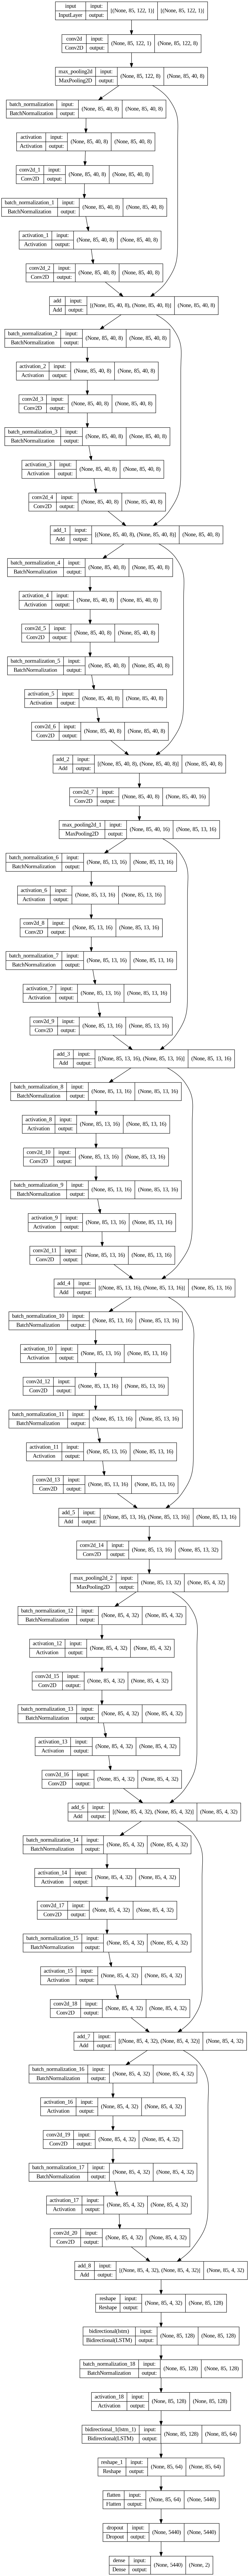

In [17]:
# to save a png of the model you need pydot and graphviz installed
plot_model(sr.m,
           to_file = './models/{}_{}.png'.format(arch,date), 
           show_shapes = True)

In [50]:
def step_decay(epoch):
   initial_lrate = 0.4
   # drop = 0.5
   # epochs_drop = 10.0
   fastest_decay_epicentrum = 500
   epochs_of_fast_decaying = 100
   lrate = initial_lrate * (math.atan(-(epoch-fastest_decay_epicentrum)/epochs_of_fast_decaying) + 0.875 * math.pi/2) * 0.34
   # lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
   return lrate

#callbacks, remember to make folders to store files 
checkpointer = ModelCheckpoint(filepath='./models/{}_{}_best.h5'.format(arch, date),
                               verbose=0,
                               save_best_only=True)
   
earlystopping = EarlyStopping()

tensorboard = TensorBoard(log_dir = './logs/{}_{}'.format(date, time()), 
                          histogram_freq = 0, 
                          write_graph = True, 
                          write_images = True)
sheluder = LearningRateScheduler(step_decay, verbose=0)

v = np.arange(1,1000,1)
w = [step_decay(x) for x in v]
print(w[-1])

0.00019466705931831996


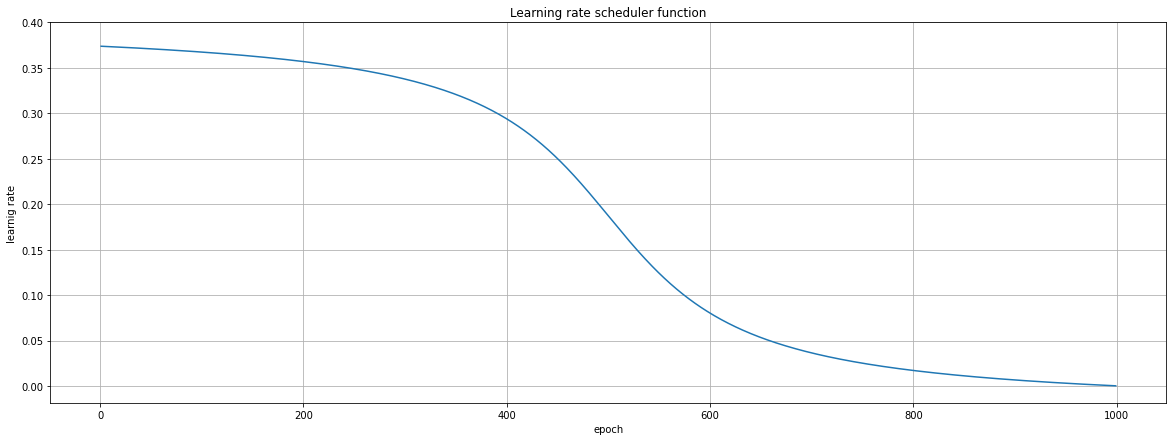

In [51]:
plt.plot(v,w)
plt.title('Learning rate scheduler function')
plt.xlabel('epoch')
plt.ylabel('learnig rate')
plt.ylim(top=0.4)
plt.grid()
plt.show()

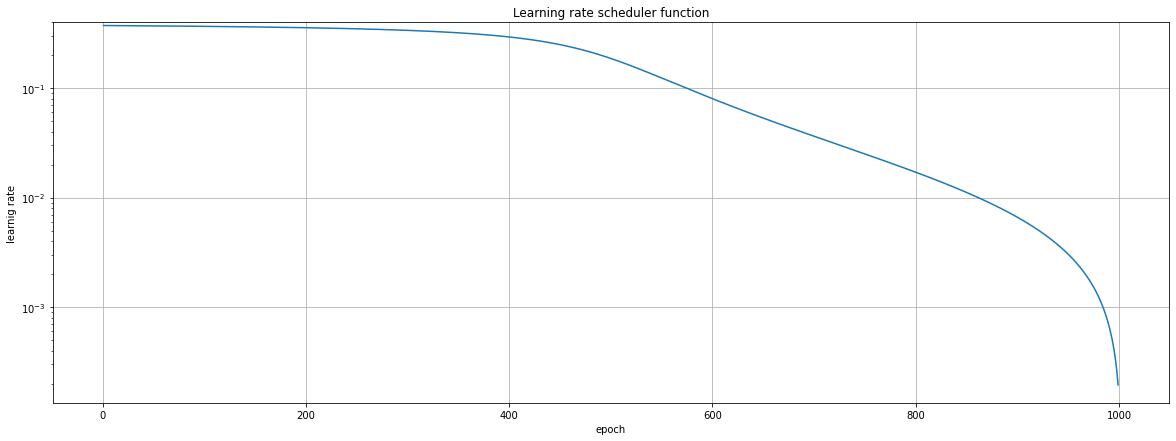

In [52]:
plt.plot(v,w)
plt.title('Learning rate scheduler function')
plt.xlabel('epoch')
plt.ylabel('learnig rate')
plt.yscale('log')
plt.ylim(top=0.4)
plt.grid()
plt.show()

### Load model weights (optional)

In [47]:
!ls /home2/faculty/kmrozowski/models/

resnetlstm8_16_32_128_20220430_best.h5
resnetlstm8_16_32_128_20220431_best.h5
resnetlstm8_16_32_128_binary_20220431_best.h5
resnetlstm8_16_32_128_binary_20220502_best.h5
resnetlstm8_16_32_128_secondary_20220502_best.h5
resnetlstm8_16_32_128_secondary_20220502_last.h5


In [48]:
path = '/home2/faculty/kmrozowski/models/'
sr.m.load_weights(path + 'resnetlstm8_16_32_128_binary_rev_20220504_best.h5')

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/home2/faculty/kmrozowski/models/resnetlstm8_16_32_128_binary_rev_20220504_best.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

### Train the model. The history object stores training data for later access, like plotting training curves

In [53]:
history = sr.m.fit(X_train, 
                   to_categorical(Y_train_binary),
                   batch_size = batch_size,
                   epochs = 1000,
                   verbose = 1, shuffle = True, 
                   class_weight = class_weights_binary,
                   validation_data = (X_val, to_categorical(Y_val_binary)), 
                   callbacks = [checkpointer, tensorboard, sheluder]) # add more callbacks if you want

/mnt/evafs/faculty/home/kmrozowski/rl2/inkub-env/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/1000
595/595 [==============================] - 29s 48ms/step - loss: 0.1157 - accuracy: 0.9698 - val_loss: 0.2147 - val_accuracy: 0.9232 - lr: 0.3737
Epoch 2/1000
595/595 [==============================] - 28s 48ms/step - loss: 0.1054 - accuracy: 0.9725 - val_loss: 0.3351 - val_accuracy: 0.8947 - lr: 0.3737
Epoch 3/1000
595/595 [==============================] - 28s 48ms/step - loss: 0.0963 - accuracy: 0.9745 - val_loss: 0.2827 - val_accuracy: 0.8982 - lr: 0.3736
Epoch 4/1000
595/595 [==============================] - 28s 48ms/step - loss: 0.0849 - accuracy: 0.9782 - val_loss: 0.3182 - val_accuracy: 0.9009 - lr: 0.3735
Epoch 5/1000
595/595 [==============================] - 28s 48ms/step - loss: 0.0811 - accuracy: 0.9789 - val_loss: 0.1969 - val_accuracy: 0.9297 - lr: 0.3735
Epoch 6/1000
221/595 [==========>...................] - ETA: 17s - loss: 0.0683 - accuracy: 0.9826

In [ ]:
sr.m.save_weights("./models/{}_{}_last.h5".format(arch, date))

### Plot the training graphs, and save them

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


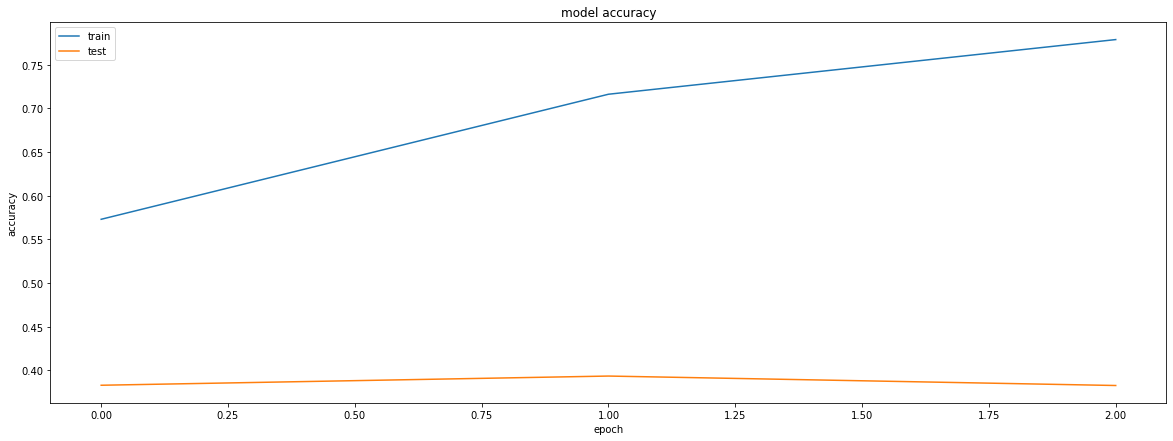

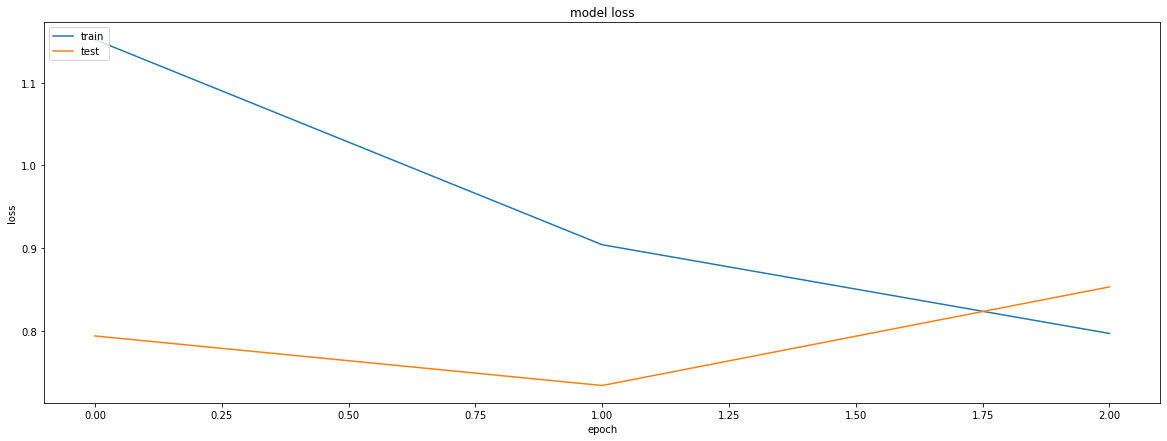

In [ ]:
#%% visualize training
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/{}_{}_acc.png'.format(arch, date),bbox_inches='tight')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/{}_{}_loss.png'.format(arch, date), bbox_inches='tight')
plt.show()

### Predict the validation classification and score

In [ ]:
val_pred = sr.m.predict(X_val, batch_size = batch_size, verbose = 1)

35/35 [==============================] - 8s 199ms/step


In [ ]:
print(classification_report(Y_val_binary, np.argmax(val_pred, axis = 1), target_names = classes_binary, digits = 3))

              precision    recall  f1-score   support

       known      0.383     0.999     0.553      2618
     unknown      0.000     0.000     0.000      4221

    accuracy                          0.383      6839
   macro avg      0.191     0.500     0.277      6839
weighted avg      0.146     0.383     0.212      6839



In [ ]:
print(confusion_matrix(Y_val_binary, np.argmax(val_pred, axis = 1)))
# [[1973  645]
#  [ 460 3761]]

[[2616    2]
 [4221    0]]


In [ ]:
cf_mat = confusion_matrix(Y_val_binary, np.argmax(val_pred, axis = 1))
b = cf_mat.copy()
sum = 0.0
sum_diag = 0.0
for i in range(cf_mat.shape[0]):
   for j in range(cf_mat.shape[0]):
      if j != i:
         sum += cf_mat[i][j]
      else:
         sum_diag += cf_mat[i][j]
acc = sum_diag / (sum + sum_diag)
print('acc =', acc)

acc = 0.3825120631671297


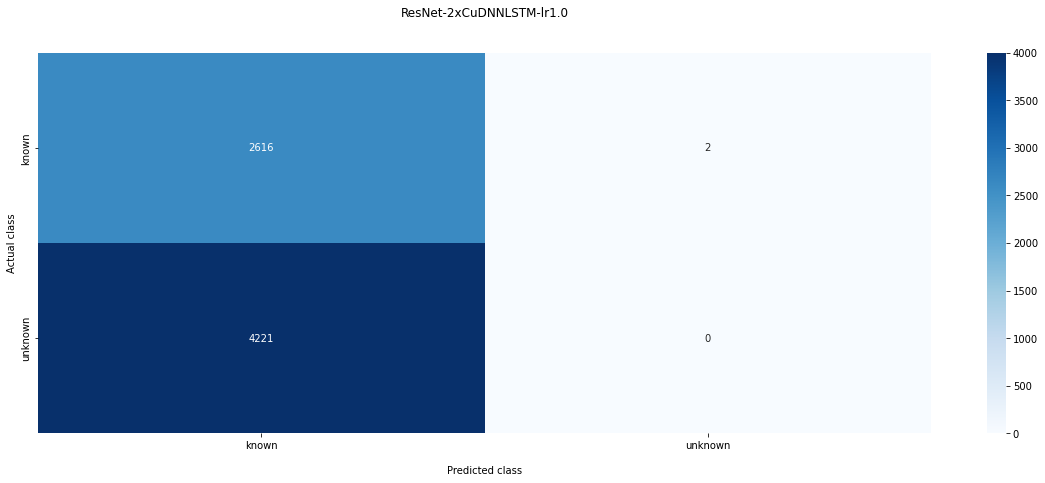

In [ ]:
ax = sns.heatmap(cf_mat, annot=cf_mat, fmt='', cmap='Blues', vmin=0, vmax=4000)
ax.set_title('ResNet-2xCuDNNLSTM-lr1.0\n\n')
ax.set_xlabel('\nPredicted class')
ax.set_ylabel('Actual class')
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(classes_binary)
ax.yaxis.set_ticklabels(classes_binary)
plt.show()

### convert spectrogram to audio (doesn't work D: )

In [ ]:
errors_path = '/home2/faculty/kmrozowski/rl2/wut-mini-deep-learning/speech-recognition/data/errors/'
for actual_label in range(cf_mat.shape[0]):
   for predicted_label in range(cf_mat.shape[1]):
      err_name = classes[actual_label] + '_' + classes[predicted_label]
for i, (x, actual_label, predicted_label) in enumerate(zip(X_val, Y_val, np.argmax(val_pred, axis = 1))):
   if i < 1000:
      continue
   if actual_label != predicted_label:
      if classes[actual_label] == 'unknown' or classes[predicted_label] == 'unknown':
         continue
      err_name = classes[actual_label] + '_' + classes[predicted_label]
      if not os.path.exists(errors_path + err_name):
            os.makedirs(errors_path + err_name)
      # audio_signal = librosa.feature.inverse.mel_to_audio(x.transpose([1,0,2])[:,:,0], sr=16000)
      audio_signal = librosa.core.spectrum.griffinlim(x.transpose([1,0,2])[:,:,0])
      print(classes[actual_label] + ' != ' + classes[predicted_label], x.transpose([1,0,2]).shape, i, audio_signal.shape)
      output_path = errors_path + err_name + '/error_' + str(i) + '.wav'
      sf.write(output_path, audio_signal, 16000, format='wav')
      plt.plot(audio_signal)
      break

   

### Divide validation/train set into knowns and unknowns

In [ ]:
def binary_to_known(X, Y, Y_binary, label, labels):
   X_label = []
   Y_label = []
   for x, y, y_binary in zip(X, Y, Y_binary):
      if labels[y_binary] == label:
         X_label.append(x)
         Y_label.append(y)
   return (np.array(X_label), np.array(Y_label))

X_train_known, Y_train_known = binary_to_known(X_train, Y_train, Y_train_binary, 'known', classes_binary)
X_val_known, Y_val_known = binary_to_known(X_val, Y_val, Y_val_binary, 'known', classes_binary)

# The real ResNet

In [ ]:
class_weights_known = get_class_weights(Y_train_known)
class_weights_known

{3: 1.0476190476190477,
 9: 1.0476190476190477,
 4: 1.0476190476190477,
 1: 1.0476190476190477,
 7: 1.0476190476190477,
 6: 1.0476190476190477,
 5: 1.0476190476190477,
 8: 1.0476190476190477,
 2: 1.0,
 0: 1.0,
 10: 3.6666666666666665}

In [ ]:
#filters_size should not change
output_size = 11
arch = 'resnetlstm8_16_32_128_secondary_rev'

In [ ]:
sr2 = ResNetLstm(filters_list, input_size, output_size)
sr2.build()
sr2.m.compile(loss='categorical_crossentropy', 
             optimizer=Adadelta(learning_rate=1.0,
                                rho=0.95,
                                epsilon=1e-07,
                                name="Adadelta"),
             metrics=['accuracy'])

1shapes:  (85, 122, 1)
2shapes:  (None, 85, 122, 8)
3shapes:  (None, 85, 40, 8)
16
6shapes:  (None, 85, 13, 16)
32
6shapes:  (None, 85, 4, 32)
7shapes:  (None, 85, 128)
8shapes:  (None, 85, 128)
9shapes:  (None, 85, 64)
0shapes:  (None, 85, 64)
output_size:  11
1shapes:  (None, 5440)
2shapes:  (None, 11)


In [ ]:
sr2.m.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 85, 122, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 85, 122, 8)   80          ['input[0][0]']                  
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 85, 40, 8)   0           ['conv2d_21[0][0]']              
                                                                                                  
 batch_normalization_19 (BatchN  (None, 85, 40, 8)   32          ['max_pooling2d_3[0][0]']  

 ormalization)                                                                                    
                                                                                                  
 activation_27 (Activation)     (None, 85, 13, 16)   0           ['batch_normalization_27[0][0]'] 
                                                                                                  
 conv2d_31 (Conv2D)             (None, 85, 13, 16)   2320        ['activation_27[0][0]']          
                                                                                                  
 batch_normalization_28 (BatchN  (None, 85, 13, 16)  64          ['conv2d_31[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_28 (Activation)     (None, 85, 13, 16)   0           ['batch_normalization_28[0][0]'] 
          

 conv2d_41 (Conv2D)             (None, 85, 4, 32)    9248        ['activation_36[0][0]']          
                                                                                                  
 add_17 (Add)                   (None, 85, 4, 32)    0           ['conv2d_41[0][0]',              
                                                                  'add_16[0][0]']                 
                                                                                                  
 reshape_2 (Reshape)            (None, 85, 128)      0           ['add_17[0][0]']                 
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 85, 128)     98816       ['reshape_2[0][0]']              
 )                                                                                                
                                                                                                  
 batch_nor

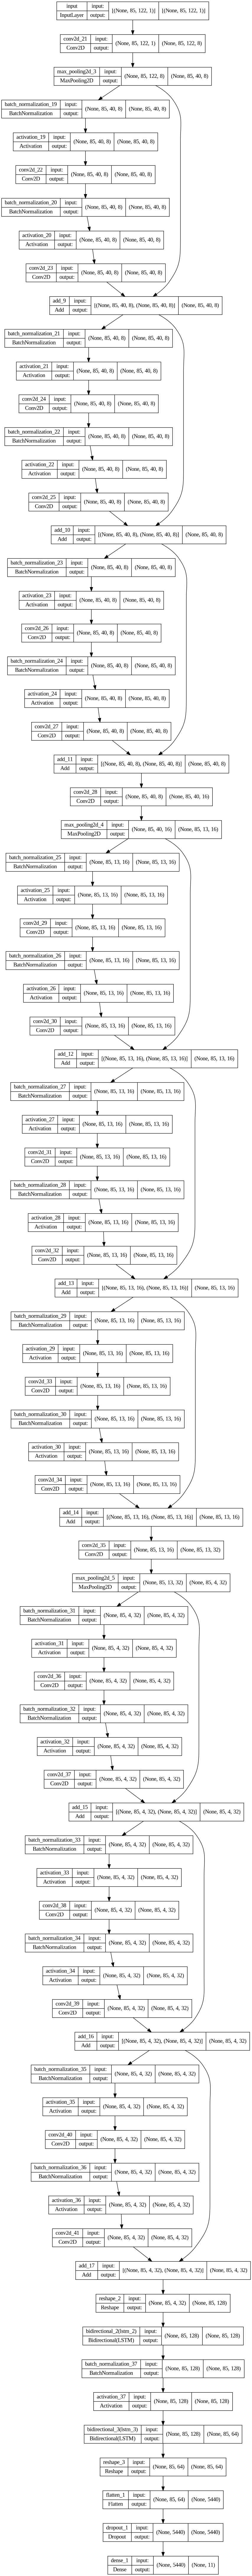

In [37]:
plot_model(sr2.m,
           to_file = './models/{}_{}.png'.format(arch,date), 
           show_shapes = True)

In [ ]:
# Copy the weights for all but last layer.
for i in range(len(sr.m.layers) - 1):
    sr2.m.layers[i].set_weights(sr.m.layers[i].get_weights())
for i in range(len(sr2.m.layers) - 7):
    sr2.m.layers[i].trainable = False
sr2.m.compile(loss='categorical_crossentropy', 
             optimizer=Adadelta(learning_rate=1.0,
                                rho=0.95,
                                epsilon=1e-07,
                                name="Adadelta"),
             metrics=['accuracy'])

In [ ]:
history2 = sr2.m.fit(X_train_known, 
                   to_categorical(Y_train_known), 
                   batch_size = batch_size,
                   epochs = 30,
                   #epochs = 3,
                   verbose = 1, shuffle = True,
                   class_weight = class_weights_known,
                   validation_data = (X_val_known, to_categorical(Y_val_known)), 
                   callbacks = [checkpointer, tensorboard, sheluder]) # add more callbacks if you want

Epoch 1/3
2/2 [==============================] - 8s 4s/step - loss: 2.7808 - accuracy: 0.0688 - val_loss: 2.4056 - val_accuracy: 0.1035 - lr: 0.3653
Epoch 2/3
2/2 [==============================] - 3s 3s/step - loss: 2.5170 - accuracy: 0.1972 - val_loss: 2.3955 - val_accuracy: 0.1054 - lr: 0.3653
Epoch 3/3
2/2 [==============================] - 3s 3s/step - loss: 2.3512 - accuracy: 0.2110 - val_loss: 2.3655 - val_accuracy: 0.1070 - lr: 0.3652


In [ ]:
for i in range(len(sr2.m.layers) - 7):
    sr2.m.layers[i].trainable = True
sr2.m.compile(loss='categorical_crossentropy', 
             optimizer=Adadelta(learning_rate=1.0,
                                rho=0.95,
                                epsilon=1e-07,
                                name="Adadelta"),
             metrics=['accuracy'])

In [ ]:
def step_decay(epoch):
   initial_lrate = 0.4
   fastest_decay_epicentrum = 1000
   epochs_of_fast_decaying = 250
   lrate = initial_lrate * (math.atan(-(epoch-fastest_decay_epicentrum)/epochs_of_fast_decaying) + 0.922 * math.pi/2) * 0.34
   # lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
   return lrate

#callbacks, remember to make folders to store files 
checkpointer = ModelCheckpoint(filepath='./models/{}_{}_best.h5'.format(arch, date),
                               verbose=0,
                               save_best_only=True)
   
earlystopping = EarlyStopping()

tensorboard = TensorBoard(log_dir = './logs/{}_{}'.format(date, time()), 
                          histogram_freq = 0, 
                          write_graph = True, 
                          write_images = True)
sheluder = LearningRateScheduler(step_decay, verbose=0)

v = np.arange(1,3000,1)
w = [step_decay(x) for x in v]
print(w[-1])

0.0002576451767440453


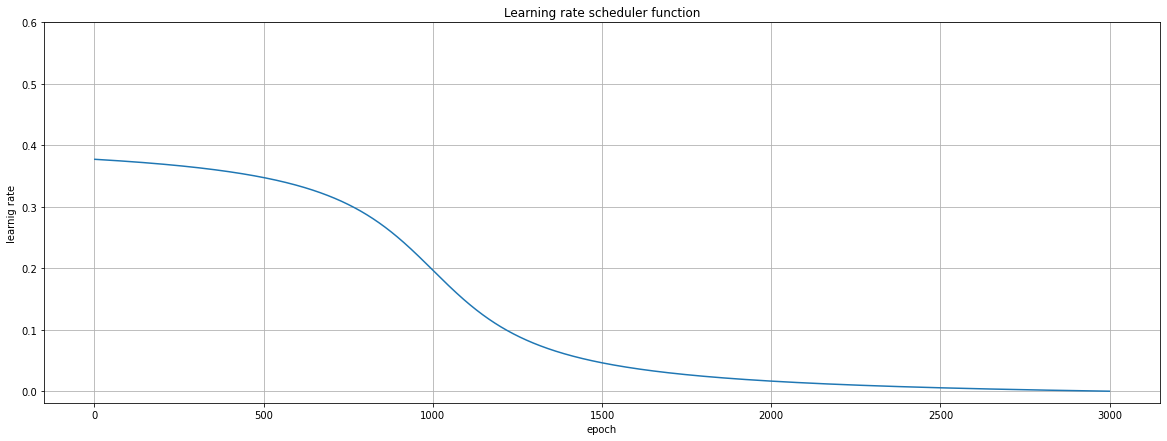

In [ ]:
plt.plot(v,w)
plt.title('Learning rate scheduler function')
plt.xlabel('epoch')
plt.ylabel('learnig rate')
plt.ylim(top=0.6)
plt.grid()
plt.show()

In [ ]:
history3 = sr2.m.fit(X_train_known, 
                   to_categorical(Y_train_known), 
                   batch_size = 64,
                   epochs = 3000,
                   #epochs = 3,
                   verbose = 1, shuffle = True, 
                   class_weight = class_weights_known,
                   validation_data = (X_val_known, to_categorical(Y_val_known)), 
                   callbacks = [checkpointer, tensorboard, sheluder]) # add more callbacks if you want
# 4 -> 100, 18 -> 249

Epoch 1/3
4/4 [==============================] - 10s 2s/step - loss: 2.5819 - accuracy: 0.1468 - val_loss: 2.4149 - val_accuracy: 0.1039 - lr: 0.3773
Epoch 2/3
4/4 [==============================] - 4s 1s/step - loss: 2.1110 - accuracy: 0.3394 - val_loss: 2.4092 - val_accuracy: 0.1020 - lr: 0.3772
Epoch 3/3
4/4 [==============================] - 4s 1s/step - loss: 1.8574 - accuracy: 0.4541 - val_loss: 2.4090 - val_accuracy: 0.1154 - lr: 0.3772


In [ ]:
sr.m.save_weights("./models/{}_{}_last.h5".format(arch, date))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


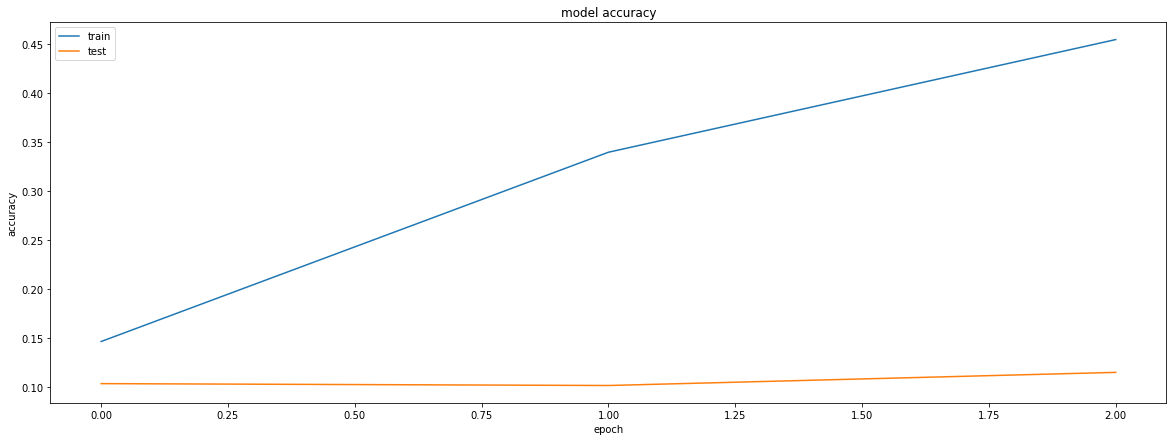

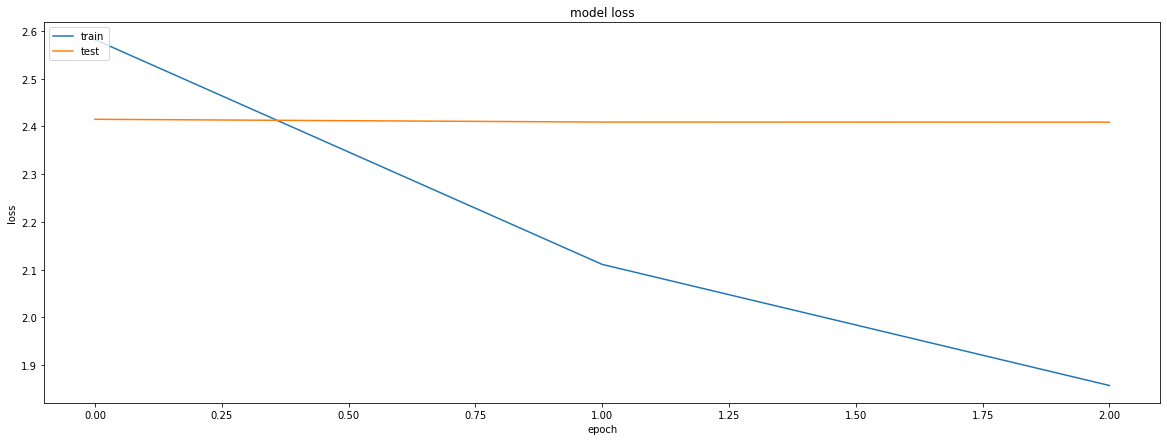

In [ ]:
#%% visualize training
print(history3.history.keys())
# summarize history for accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/{}_{}_acc.png'.format(arch, date),bbox_inches='tight')
plt.show()
# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/{}_{}_loss.png'.format(arch, date), bbox_inches='tight')
plt.show()

In [ ]:
val_pred_known = sr2.m.predict(X_val_known, batch_size = batch_size, verbose = 1)

14/14 [==============================] - 4s 186ms/step


In [ ]:
print(classification_report(Y_val_known, np.argmax(val_pred_known, axis = 1), target_names = classes_known, digits = 3))

              precision    recall  f1-score   support

         yes      0.000     0.000     0.000       261
          no      0.169     0.096     0.123       270
          up      0.117     0.954     0.209       260
        down      0.000     0.000     0.000       264
        left      0.000     0.000     0.000       247
       right      0.020     0.004     0.007       256
          on      0.000     0.000     0.000       257
         off      0.000     0.000     0.000       256
        stop      0.073     0.033     0.045       246
          go      0.102     0.073     0.085       260
     silence      0.000     0.000     0.000        41

    accuracy                          0.115      2618
   macro avg      0.044     0.105     0.043      2618
weighted avg      0.048     0.115     0.047      2618



/home/metiulekm/.local/share/virtualenvs/speech-recognition-YZGLRYX1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/metiulekm/.local/share/virtualenvs/speech-recognition-YZGLRYX1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/metiulekm/.local/share/virtualenvs/speech-recognition-YZGLRYX1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. U

In [ ]:
print(confusion_matrix(Y_val_known, np.argmax(val_pred_known, axis = 1)))
# Before separate network for unknowns:
# [[ 231    4    0    9    0    0    1    0    4    4    1    7]
#  [   0  170    0   21    0    0    0    0    2   69    0    8]
#  [   0    0  203    1    0    0    5    1   39    6    2    3]
#  [   0    4    0  245    0    0    0    0    3   11    0    1]
#  [  11    5    0    7  192    0    1    0   14    8    1    8]
#  [   0    1    1    0    4  213    8    0    2    6    0   21]
#  [   0    0    2    1    0    0  247    1    1    1    3    1]
#  [   0    0   11    0    0    0   46  177   15    4    0    3]
#  [   1    0    0    5    0    0    1    0  230    6    1    2]
#  [   0    1    1   13    0    0    2    2    3  231    5    2]
#  [   0    0    0    0    0    0    0    0    0    0   41    0]
#  [   9   32   25  321   13   19  321   10  125  322   18 3006]]
#After:

[[  0  21 206   0   0   6   0   0  15  13   0]
 [  0  26 210   0   0   5   0   0   6  23   0]
 [  0   2 248   0   0   1   0   0   4   5   0]
 [  0  43 175   0   0  15   0   0   5  26   0]
 [  0   2 213   0   0   1   0   0   7  24   0]
 [  0  10 219   0   0   1   0   0   7  19   0]
 [  0  23 196   0   0   1   0   0   9  28   0]
 [  0  13 216   0   0   4   0   0   5  18   0]
 [  0   3 216   0   0   7   0   0   8  12   0]
 [  0   9 217   0   0   7   0   0   8  19   0]
 [  0   2   1   0   0   3   0   0  35   0   0]]


In [ ]:
cf_mat = confusion_matrix(Y_val_known, np.argmax(val_pred_known, axis = 1))
b = cf_mat.copy()
sum = 0.0
sum_diag = 0.0
for i in range(cf_mat.shape[0]):
   for j in range(cf_mat.shape[0]):
      if j != i:
         sum += cf_mat[i][j]
      else:
         sum_diag += cf_mat[i][j]
acc = sum_diag / (sum + sum_diag)
print('acc =', acc)

acc = 0.11535523300229182


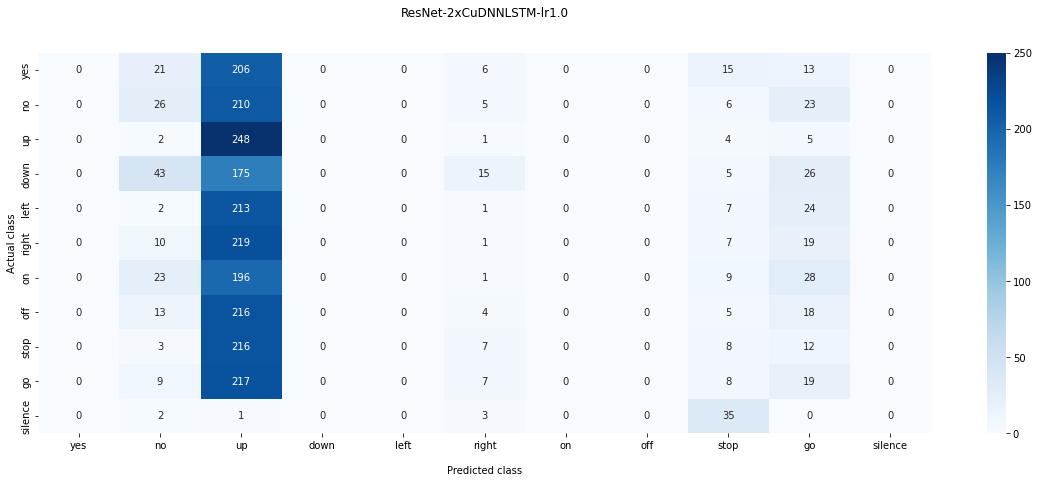

In [ ]:
ax = sns.heatmap(cf_mat, annot=cf_mat, fmt='', cmap='Blues', vmin=0, vmax=250)
ax.set_title('ResNet-2xCuDNNLSTM-lr1.0\n\n')
ax.set_xlabel('\nPredicted class')
ax.set_ylabel('Actual class')
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(classes_known)
ax.yaxis.set_ticklabels(classes_known)
plt.show()